# uvfmeas of secondary

I'm interested in how consistent or variable the uvfmeas spectrum of the secondary calibrator is. 

I hope to assess how much it changes across time and between bands. It might make sense to fit some type of model to use in `gpcal` for use as a flux calibrator. Although this is not completely necessary, since I plan on using both IFs together it would be important to ensure a consistent calibration. 

It looks like in semester two where the `tvmedian` option was used that the spectrum is a lot nice across both bands. The semester one data not so much. 

In [1]:
% matplotlib inline
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def uvfmeas_logs(freq):
    files = glob.glob(f'../Data/*/Plots/secondary_uvfmeas_{freq}_log.txt')
    dfs = []

    for f in files:
        print(f"Loading {f}")
        date = f.split('/')[2]
        print(f"\t{date}")
        df = pd.read_csv(f, names=('nu','s_nu','s_model'), delim_whitespace=True)
        df['date'] = date

        dfs.append(df)

    return pd.concat(dfs)

df_7 = uvfmeas_logs('7700')
df_9 = uvfmeas_logs('9500')

Loading ../Data/2017-12-18/Plots/secondary_uvfmeas_7700_log.txt
	2017-12-18
Loading ../Data/2017-12-16/Plots/secondary_uvfmeas_7700_log.txt
	2017-12-16
Loading ../Data/2017-12-17/Plots/secondary_uvfmeas_7700_log.txt
	2017-12-17
Loading ../Data/2018-06-23/Plots/secondary_uvfmeas_7700_log.txt
	2018-06-23
Loading ../Data/2018-06-07/Plots/secondary_uvfmeas_7700_log.txt
	2018-06-07
Loading ../Data/2018-01-10/Plots/secondary_uvfmeas_7700_log.txt
	2018-01-10
Loading ../Data/2018-06-08/Plots/secondary_uvfmeas_7700_log.txt
	2018-06-08
Loading ../Data/2018-06-30/Plots/secondary_uvfmeas_7700_log.txt
	2018-06-30
Loading ../Data/2018-06-06/Plots/secondary_uvfmeas_7700_log.txt
	2018-06-06
Loading ../Data/2018-06-01/Plots/secondary_uvfmeas_7700_log.txt
	2018-06-01
Loading ../Data/2017-11-24/Plots/secondary_uvfmeas_7700_log.txt
	2017-11-24
Loading ../Data/2017-11-23/Plots/secondary_uvfmeas_7700_log.txt
	2017-11-23
Loading ../Data/2018-07-01/Plots/secondary_uvfmeas_7700_log.txt
	2018-07-01
Loading ../D

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


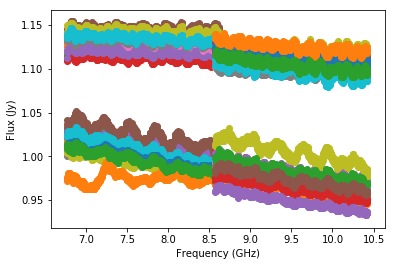

In [3]:
fig, ax = plt.subplots(1,1)

for index, sub in df_7.groupby('date'):
    ax.scatter(sub['nu'], sub['s_nu'])

for index, sub in df_9.groupby('date'):
    ax.scatter(sub['nu'], sub['s_nu'])

ax.set(xlabel='Frequency (GHz)', ylabel='Flux (Jy)')    

fig.show()

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


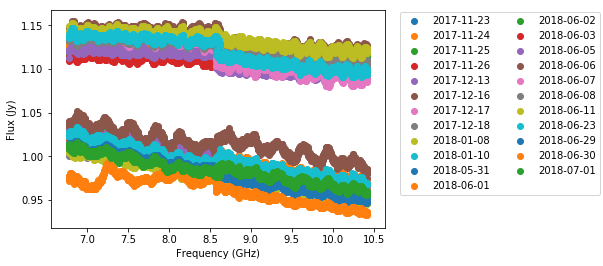

In [4]:
fig, ax = plt.subplots(1,1)

for index, _ in df_7.groupby('date'):
    mask1 = df_7['date'] == index
    mask2 = df_9['date'] == index
    
    ax.scatter(pd.concat([df_7.loc[mask1, 'nu'], df_9.loc[mask2, 'nu']]), 
               pd.concat([df_7.loc[mask1, 's_nu'], df_9.loc[mask2, 's_nu']]),
              label=index)

ax.set(xlabel='Frequency (GHz)', ylabel='Flux (Jy)')    

fig.legend(ncol=2,bbox_to_anchor=(1.4, 0.9))
fig.show()

In [5]:
df7 = pd.read_csv('../Data/2018-07-01/Plots/secondary_uvfmeas_7700_log.txt', names=('nu','s_nu','s_model'), delim_whitespace=True)
df9 = pd.read_csv('../Data/2018-07-01/Plots/secondary_uvfmeas_9500_log.txt', names=('nu','s_nu','s_model'), delim_whitespace=True)

In [6]:
nu7, snu7 = df7['nu'].values, df7['s_nu'].values
nu9, snu9 = df9['nu'].values, df9['s_nu'].values

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


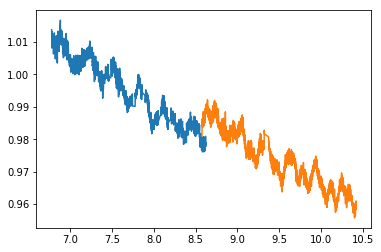

In [7]:
fig, ax = plt.subplots(1,1)

ax.plot(nu7, snu7)
ax.plot(nu9, snu9)

fig.show()

In [8]:
def pl(nu, *p):
    norm, alpha = p
    return norm + alpha*np.log10(nu/8.5)

In [9]:
from scipy.optimize import curve_fit

In [10]:
fit7 = curve_fit(pl, nu7, snu7, (1., -0.7))
fit9 = curve_fit(pl, nu9, snu9, (1., -0.7))

In [11]:
print(fit7[0])
print(fit9[0])

[ 0.98167485 -0.29970409]
[ 0.9892027  -0.32794447]


In [12]:
nom7 = np.median(pl(nu7[-50:], *fit7[0]))
nom9 = np.median(pl(nu9[:50], *fit9[0]))

print(nom7, nom9)

fact = nom9/nom7

print(fact)

0.980190342105 0.987512063307
1.00746969327


/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


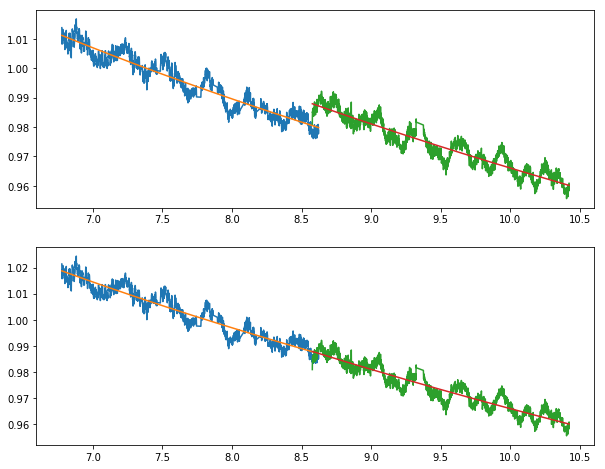

In [13]:
fig, (ax,ax1) = plt.subplots(2,1, figsize=(10,8))

ax.plot(nu7, snu7)
ax.plot(nu7, pl(nu7, *fit7[0]))

ax.plot(nu9, snu9)
ax.plot(nu9, pl(nu9, *fit9[0]))

ax1.plot(nu7, snu7*fact)
ax1.plot(nu7, pl(nu7, *fit7[0])*fact)

ax1.plot(nu9, snu9)
ax1.plot(nu9, pl(nu9, *fit9[0]))

fig.show()

In [14]:
def mfcal_test(fit, nu_0=8.5, fact=1):
    flux_str = f"{nu_0},{fit[0][0]*fact:.2f},{fit[0][1]:.2f}"
        
    return flux_str

In [15]:
mfcal_test(fit9)

'8.5,0.99,-0.33'

In [16]:
mfcal_test(fit7, fact=fact)

'8.5,0.99,-0.30'

In [17]:
mfcal_test(fit7)

'8.5,0.98,-0.30'

In [25]:
def mfcal_flux(fit, nu_0=8.5, ifcal=1):
    if ifcal == 1:
        flux_str = f"{nu_0},{fit[0][0]*fit[2]:.2f},{fit[0][1]:.2f}"
    else:
        flux_str = f"{nu_0},{fit[1][0]:.2f},{fit[1][1]:.2f}"
        
    return flux_str

def pl(nu, *p):
    norm, alpha = p
    return norm + alpha*np.log10(nu/8.5)

def model_secondary(date, plot=True):
    """Function to scale IF1 onto IF2. 
    """
    df7 = pd.read_csv(f'../Data/{date}/Plots/secondary_uvfmeas_7700_log.txt', names=('nu','s_nu','s_model'), delim_whitespace=True)
    df9 = pd.read_csv(f'../Data/{date}/Plots/secondary_uvfmeas_9500_log.txt', names=('nu','s_nu','s_model'), delim_whitespace=True)
    
    nu7, snu7 = df7['nu'].values, df7['s_nu'].values
    nu9, snu9 = df9['nu'].values, df9['s_nu'].values
    
    fit7 = curve_fit(pl, nu7, snu7, (1., -0.7))
    fit9 = curve_fit(pl, nu9, snu9, (1., -0.7))
    
    nom7 = np.median(pl(nu7[-50:], *fit7[0]))
    nom9 = np.median(pl(nu9[:50], *fit9[0]))

    fact = nom9/nom7
    
    if plot:
        fig, (ax,ax1) = plt.subplots(2,1, figsize=(10,8))

        ax.plot(nu7, snu7)
        ax.plot(nu7, pl(nu7, *fit7[0]))

        ax.plot(nu9, snu9)
        ax.plot(nu9, pl(nu9, *fit9[0]))

        ax1.plot(nu7, snu7*fact)
        ax1.plot(nu7, pl(nu7, *fit7[0])*fact)

        ax1.plot(nu9, snu9)
        ax1.plot(nu9, pl(nu9, *fit9[0]))

        fig.show()
    
    return (fit7[0], fit9[0], fact)

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


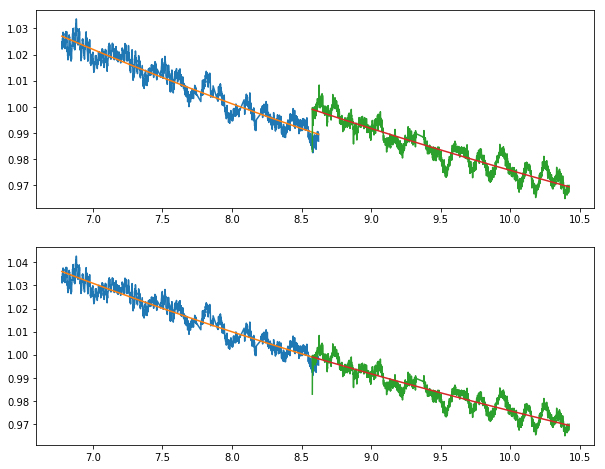

In [26]:
a = model_secondary('2018-06-23')

In [27]:
mfcal_flux(a, ifcal=2)

'8.5,1.00,-0.35'

In [28]:
mfcal_flux(a, ifcal=1)

'8.5,1.00,-0.36'